In [3]:
import yaml
from typing import List, Dict
from sklearn.model_selection import train_test_split
import uproot
import os
import glob
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, hinge_loss, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

2025-07-27 20:50:55.610082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-27 20:50:55.610111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-27 20:50:55.647667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-27 20:50:55.727792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-27 20:50:58.663545: W tensorflow/compiler/tf2

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
class mlpScikitPlotClassifier:
    def __init__(self, yaml_file: str): # identifying that the yaml file should be a string
        """
        Initialize with configurations from a YAML file.
        :param yaml_file: Path to the YAML configuration file.
        """
        # defining each of the attributes
        self.input_paths = None
        self.samples = {}
        self.variables = []
        self.hyperparameters = {}
        self.model = None
        self.dataframes = {"background": None, "signal": None}

        # calling two of the functions up here, even though only defined below
        # can do this bc reads classes all first, then goes through
        self._parse_yaml(yaml_file)
        self._load_data()

    def prepare_gpu(self):
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                    print("Memory growth enabled")
            except RuntimeError as e:
                print("Memory growth setup failed:", e)

    def _parse_yaml(self, yaml_file: str):
        try: # try means that if error happens, it'll go to exception
            # use 'with' to make sure that yaml file is closed after it's opened
            with open(yaml_file, 'r' ) as file: # telling to read the file and call it "file"
                config = yaml.safe_load(file)

            # defining the attributes from things inside yaml file
            self.input_paths = config['input_path']
            self.samples[0] = config.get(0, []) # defining first column of samples as those under the key 0 in the yaml file - also, if 0 doesn't exist, return empty list "[]"
            self.samples[1] = config.get(1, []) # defining second column of samples to be things under key 1 in file
            self.variables = config.get('variables', []) # defining variables to be things under key 'variables'

        # if error occurs inside the try, will give this formatted error
        except Exception as e:
            raise ValueError(f"Error parsing YAML file: {e}") # f-string that lets you embed variables in string

    def _load_data(self):
        for sample_type, key in [("background", 0), ("signal", 1)]: # iterating this for loop, once for signal, once for background
            sample_list = self.samples[key] # calling all the background/signal samples
            dataframes = []

            for sample in sample_list:
                files = glob.glob(os.path.join(f"{self.input_paths}/{sample}/", "*.root")) # joining the sample with input path and making root file
                for file in files: ## why do we need this for loop, if there should only be one file found for each sample?
                    self.tree = uproot.open(file)['analysis'] # opening root file and ttree
                    variables_with_b_w = self.variables + ['b_w']
                    df = self.tree.arrays(variables_with_b_w, library="pd") # turning tree into pd df
                    df['sample'] = sample # adding column for sample name
                    df['label'] = key # adding column for 0 or 1
                    dataframes.append(df) # adding all background df into one list

            combined_df = pd.concat(dataframes, ignore_index=True).dropna() # concatinating the list of df into one full df
            self.dataframes[sample_type] = combined_df # making the df an attribute, and placing them in dictionary with the key of either signal or background

    def print_config(self):
        """Prints the current configuration."""
        print(f"Input Paths: {self.input_paths}")
        print(f"Samples: {self.samples}")
        print(f"Variables: {self.variables}")

    def prepare_data(self):
        # putting data into sep background and signal df
        self.background_df = self.dataframes["background"]
        self.signal_df = self.dataframes["signal"]

        # computing ratio between sig and back for reweighting when training model
        #self.scale = len(background_df) / len(signal_df)

        self.combined_df = pd.concat([self.background_df, self.signal_df], ignore_index=True) # combining sig and back df into one df
        # splitting df into X and y
        self.X = self.combined_df[self.variables]  # Use only the specified variables
        self.y = self.combined_df['label']
        self.weights = self.combined_df['b_w']

        # returning the train/test split so can be used later in class
        return train_test_split(self.X, self.y, self.weights, test_size=0.3, random_state=42)

    def train_model(self, model_path="xgboost_model.json", importance_plot_path=None): # function parameters with defaults (if don't pass anything when calling function)
        self.X_train, self.X_test, self.y_train, self.y_test, b_w_train, b_w_test = self.prepare_data() # defining X and y train/test

        # rescaling weights so not always predicting background
        # calculating sums 
        signal_total = b_w_train[self.y_train == 1].sum()
        back_total = b_w_train[self.y_train == 0].sum()
        # scaling the signal so it's closer to background weight
        scale_factor = back_total / signal_total
        b_w_train[self.y_train == 1] *= scale_factor
        b_w_test[self.y_test == 1] *= scale_factor
        
        inputShape = len(self.variables)
        def create_baseline():
            model = Sequential()
            model.add(tf.keras.Input(shape=(inputShape,)))
            model.add(Dense(256, activation='relu'))
            model.add(Dropout(0.3))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', 
                          optimizer=Adam(learning_rate=0.000005), 
                          metrics=[tf.keras.metrics.AUC(name='auc'),'accuracy'])

            return model

        #estimator = KerasClassifier(model=create_baseline, epochs=20, batch_size=500, verbose=1)
        #kfold = StratifiedKFold(n_splits=3, shuffle=True)
        #scorer = make_scorer(roc_auc_score, needs_proba=True)
        #results = cross_val_score(estimator, self.X_train, self.y_train, cv=kfold, scoring=scorer)
        #print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        self.nnmodel = create_baseline()
        self.full_model = self.nnmodel.fit(self.X_train, 
                                           self.y_train, 
                                           sample_weight=b_w_train, 
                                           epochs=20, 
                                           batch_size=400, 
                                           validation_data=(self.X_test, self.y_test), 
                                           callbacks=[early_stop],
                                           verbose=1)
    
    def plot_nn_score(self, save_path=None):
        if not hasattr(self, 'nnmodel'):
            raise AttributeError("The model has not been trained. Train the model before plotting NN scores.")
        
        # Generate scores using the trained model
        self.nn_scores = self.nnmodel.predict(self.X_test, batch_size=512).flatten()
        
        # get AUC score
        auc = roc_auc_score(self.y_test, self.nn_scores)
        print(f'AUC: {auc:.3f}')

        # new df with test set results
        test_df = self.X_test.copy()
        test_df['Label'] = self.y_test
        test_df['nn_score'] = self.nn_scores
        
        # Separate background and signal
        background_scores = test_df[test_df['Label'] == 0]['nn_score'] # selects rows where 'label' = 0, and then from those rows, only takes the 'BDT score' column
        signal_scores = test_df[test_df['Label'] == 1]['nn_score']
    
        # Normalize each group to unity
        background_weights = [1 / len(background_scores)] * len(background_scores) if len(background_scores) > 0 else []
        signal_weights = [1 / len(signal_scores)] * len(signal_scores) if len(signal_scores) > 0 else []
    
        # Plot histograms
        plt.figure(figsize=(10, 6))
        plt.hist(background_scores, bins=50, weights=background_weights, alpha=0.7, label='Background (Label 0)', color='blue')
        plt.hist(signal_scores, bins=50, weights=signal_weights, alpha=0.7, label='Signal (Label 1)', color='red')
    
        plt.xlabel("NN Score")
        plt.ylabel("Normalized Density")
        plt.title("Normalized NN Score Distribution (Background and Signal)")
        plt.legend(loc='best')
        plt.tight_layout()
    
        # Save the plot if a path is provided
        if save_path:
            plt.savefig(save_path)
            print(f"NN score plot saved to {save_path}")
    
        plt.show()

    def plot_feature_importance(self, feature_names=None, save_path=None):
        # plotting feature importance
        plt.figure(figsize=(10, 6))
        xgb.plot_importance(self.nnmodel, importance_type='gain')
        plt.title("Feature Importance by Gain")
        plt.tight_layout()

        # if you want to save the feature importance on something
        if save_path:
            plt.savefig(save_path)
            print(f"Feature importance plot saved to {save_path}")
    
        plt.show()

    def plot_logloss(self):
        
        # plotting log loss

        plt.figure(figsize=(10,6))
        plt.plot(self.full_model.history['loss'], label='Training set')
        plt.plot(self.full_model.history['val_loss'], label='Validation set')
        plt.xlabel('Epochs')
        plt.ylabel('Log Loss')
        plt.title('Log Loss for Epochs')
        plt.legend()
        plt.show()

    def plt_confusionmatrix(self):
        y_pred_binary = (self.nn_scores > 0.5).astype(int)

        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_binary)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
        
        cm_display.plot()
        plt.show()

    def roc_curve(self):
        fpr, tpr, thresholds = roc_curve(self.y_test, self.nn_scores)
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title("ROC Curve")
        plt.show()

In [2]:
nnPlot = mlpScikitPlotClassifier('nersc.yaml')
nnPlot.prepare_gpu()
nnPlot.train_model()
nnPlot.plot_nn_score()
nnPlot.plot_logloss()

ValueError: Error parsing YAML file: name 'yaml' is not defined

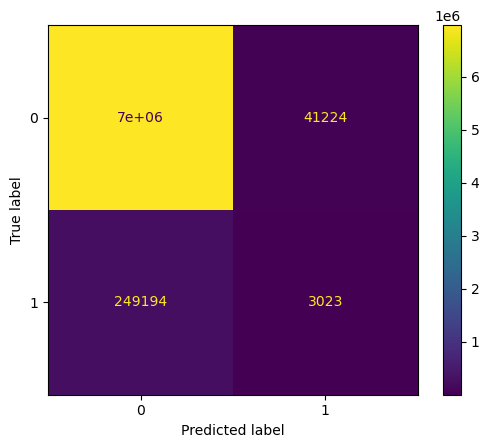

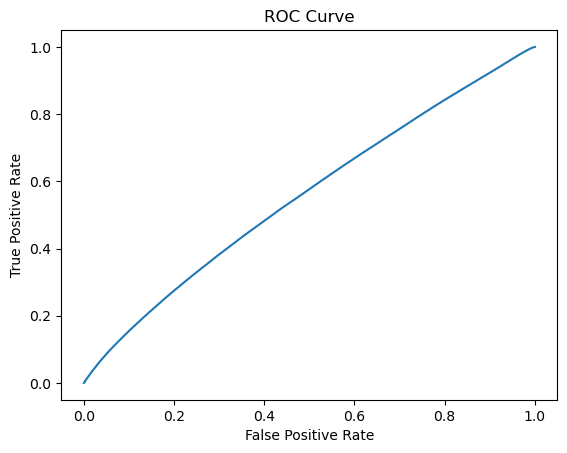

In [17]:
nnPlot.plt_confusionmatrix()
nnPlot.roc_curve()

In [4]:
import tensorflow as tf
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

X = np.random.rand(1000, 10).astype('float32')
y = np.random.randint(0, 2, size=(1000,)).astype('float32')

model = Sequential([
    Dense(32, activation='relu', input_shape=(10,)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(X, y, epochs=1, batch_size=32)


2.15.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-07-27 15:28:27.425686: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0
2025-07-27 15:28:28.857242: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa6245d1b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-27 15:28:28.857259: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-07-27 15:28:28.864697: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-27 15:28:28.926683: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
I0000 00:00:1753655309.014440  657343 device_compiler.h:186] Compiled cluster using XLA!  Thi

32/32 [==============================] - 2s 2ms/step - loss: 0.6935
